In [1]:

import os
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
assert tf.__version__ >= "2.0"
import os
from pathlib import Path


import numpy as np
import os
from pathlib import Path
import glob

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow_addons.rnn.layer_norm_lstm_cell import LayerNormLSTMCell as LSTM_norm
from tensorflow_addons.rnn.layer_norm_simple_rnn_cell import LayerNormSimpleRNNCell as RNN_norm
from sklearn.impute import SimpleImputer


In [2]:
## I retrieved eurusd data from the St. Louis Fed data base at https://fred.stlouisfed.org/series/DEXUSEU
## The data starts on Jan 4th, 1999 and ends at June 25th, 2021. I want to try and forecast the next 1-6 months of 
## EUR/USD prices using this data.


eurusd = pd.read_csv('/Users/floyd/Projects1/FOREX/EURUSD/eurusd.csv', delimiter=',', 
                     parse_dates=["DATE"], index_col="DATE")
eurusd.columns = ["EURUSD"]
print("Before imputing: \n\n", eurusd.head(15), "\n\n")


## There are missing values of the form "." that need to be eliminated prior to any analysis. 


eurusd['EURUSD'] = eurusd['EURUSD'].replace(to_replace=".", method='ffill')
eurusd["EURUSD"] = pd.to_numeric(eurusd["EURUSD"], downcast="float")
print("After imputing: \n\n", eurusd.head(15))


## We've eliminated the "." that occurs on days where there was no market for the currencies.

Before imputing: 

             EURUSD
DATE              
1999-01-04  1.1812
1999-01-05  1.1760
1999-01-06  1.1636
1999-01-07  1.1672
1999-01-08  1.1554
1999-01-11  1.1534
1999-01-12  1.1548
1999-01-13  1.1698
1999-01-14  1.1689
1999-01-15  1.1591
1999-01-18       .
1999-01-19  1.1610
1999-01-20  1.1575
1999-01-21  1.1577
1999-01-22  1.1582 


After imputing: 

             EURUSD
DATE              
1999-01-04  1.1812
1999-01-05  1.1760
1999-01-06  1.1636
1999-01-07  1.1672
1999-01-08  1.1554
1999-01-11  1.1534
1999-01-12  1.1548
1999-01-13  1.1698
1999-01-14  1.1689
1999-01-15  1.1591
1999-01-18  1.1591
1999-01-19  1.1610
1999-01-20  1.1575
1999-01-21  1.1577
1999-01-22  1.1582


<AxesSubplot:title={'center':'EUR/USD Exchange Rate'}, xlabel='Date', ylabel='EUR/USD'>

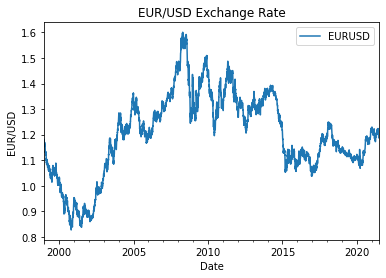

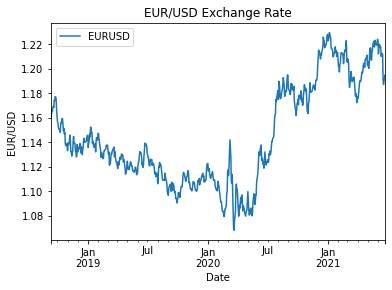

In [3]:
## Now I want to graph both the entire series as well as the past 24 months.
## The reason I'm choosing 24 months is just because we will be able to see the relationship
## before and after the pandemic began. 
## 

eurusd_18 = eurusd.iloc[-730:-1, :]
eurusd.plot(title="EUR/USD Exchange Rate", xlabel="Date", ylabel="EUR/USD")
eurusd_18.plot(title="EUR/USD Exchange Rate", xlabel="Date", ylabel="EUR/USD")


In [4]:
### Now let's look at some summary statistics of both the past two decades and two years.

print("\n", eurusd.describe(),"\n")
print(eurusd_18.describe(),"\n")



             EURUSD
count  5865.000000
mean      1.199906
std       0.160926
min       0.827000
25%       1.100900
50%       1.204000
75%       1.318700
max       1.601000 

           EURUSD
count  729.000000
mean     1.145267
std      0.041186
min      1.068200
25%      1.113000
50%      1.133700
75%      1.181900
max      1.229500 



In [5]:
## ------------------------------------------------ Recap ---------------------------------------------------- ##

## So, we can see that over the past couple decades, the EURUSD rate has averaged about 1.20 with a standard deviation
## of 0.161. The lowest this rate has ever gone was 0.827 which was in the early 2000s, which also 
## coincided the point in time where the fed funds rate was the highest it has been in the past 2 decades (about 6.5%).
## After the Fed was forced to drop rates to combat the recession tipped off by the dotcom bust, we can see that the USD
## weakened relative to the EUR by quite a lot, peaking around the time of the Great Financial Crisis. 

## Over the past couple years, we can see that the lowest the exchange rate has gone was 1.068 which was during
## the first few months of the lockdown from the pandemic, and then we've seen a rather large rebound since then.
## The rebound was caused mainly by the massive amount of monetary and fiscal stimulus that the US govt conducted in response
## to the shutdowns, and we want to determine if this trend will continue or if we should expect the EURUSD to remain
## around its historical average (of the last two decades). This model will *only* consider forecasts from
## machine learning models, and there will be no traditional time-series forecasting techniques used. However,
## I believe that it would be important to check whether this series is best modeled by a random walk, otherwise
## our longer-term forecasts might be spurious. 
##
## I am entering this analysis with zero bias towards where the rate will go, and I have no opinion on which
## machine learning model to use right now. We will try several different ones and choose the best model based on our 
## results.

## Next we will split the data between training, validation, and testing sets. Each will have 1/3 of the observations:
729/3

243.0

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

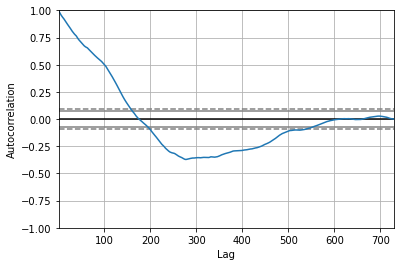

In [6]:
## Let's check to see if the data is stationary.
D_eurusd_18 = eurusd_18.diff()
pd.plotting.autocorrelation_plot(eurusd_18)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

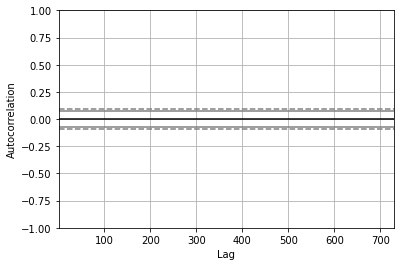

In [7]:
pd.plotting.autocorrelation_plot(D_eurusd_18)


             EURUSD
DATE              
2018-09-10 -0.0013
2018-09-11 -0.0013
2018-09-12  0.0035
2018-09-13  0.0046
2018-09-14 -0.0016 



<AxesSubplot:title={'center':'1st Difference of EUR/USD Exchange Rate'}, xlabel='Date', ylabel='1st Difference EUR/USD'>

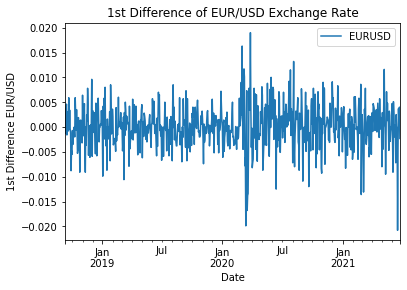

In [8]:
## So it looks like this series is pretty stationary after about 18-20 months, but the first difference 
## is obviously stationary, so this is the variable we will use for our model. 


series = D_eurusd_18
series = series.replace(method='bfill')
print("\n",series.head(), "\n")
series.plot(title="1st Difference of EUR/USD Exchange Rate", xlabel="Date", ylabel="1st Difference EUR/USD")


In [9]:
## So we now have the first difference of EURUSD for the last 2 years. This series is stationary
## and we can use the plot of it to get some indication of the volatility of this series, which we can see
## has increased quite a lot since the pandemic. How we can tell is by looking at the magnitude of the values
## of the 1st difference. 

## I'll do a forecast with both the first difference and the original series and compare the two.


#*#*#*# NOTE

## I took a break for a little bit from this project and more data came out. the extra week of data won't have much 
##  if any impact on my forecast nor will it really change the stationarity (or lack thereof) of EURUSD


In [10]:
###
###   Below is just a bunch of code to prepare my data for my ML models. 
###

import pandas as pd
import glob

path = r'/Users/floyd/Projects1/FOREX/historical' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0, delimiter=',', 
                     parse_dates=["DATE"], index_col="DATE")
    li.append(df)

forex = pd.concat(li, axis=1, ignore_index=False)

## Note: the base currency is the first currency. Example: EURUSD means whatever the value is, say 1.20,
## that you could exchange 1 Euro for 1.20 USD. Euro is called the "base" currency because it technically
## shows up in the denominator of the exchange rate: 
##                            
##                                  1.20USD
##                                  ------- = 1.20 EURUSD
##                                  1.00EUR 
## 
## I don't know why they chose to put the base currency first considering that this is the opposite of how it 
## works mathematically, but we need this established before any analysis can be understood!
## USDMXN is The peso as the numerator, KRW is the south korean won, SEK is the swedish krona, 
## CAD is canadian dollar, NZD is new zealand dollar, BRL is the brazilian real, AUD is the aussie dollar, 
## JPY is the Japanese Yen, GBP is the pound, EUR is the euro.

forex.columns = ["NZDUSD", "BRLUSD", "USDKRW", "AUDUSD", "GBPUSD", "USDJPY", "USDMXN", "EURUSD", "USDSEK", "USDCAD"]

## Now we have to impute the "." out like before.

forex = forex.replace(to_replace=".", method='ffill')

for column in forex:
    forex[column] = pd.to_numeric(forex[column], downcast="float")

print("\n", forex.dtypes, "\n\n")
forex


 NZDUSD    float32
BRLUSD    float32
USDKRW    float32
AUDUSD    float32
GBPUSD    float32
USDJPY    float32
USDMXN    float32
EURUSD    float32
USDSEK    float32
USDCAD    float32
dtype: object 




,NZDUSD,BRLUSD,USDKRW,AUDUSD,GBPUSD,USDJPY,USDMXN,EURUSD,USDSEK,USDCAD
DATE,,,,,,,,,,
1999-01-04,0.5340,1.2074,1187.500000,0.6182,1.6581,112.150002,9.831000,1.1812,8.0200,1.5268
1999-01-05,0.5370,1.2075,1166.000000,0.6217,1.6566,111.150002,9.796000,1.1760,7.9720,1.5213
1999-01-06,0.5385,1.2110,1160.000000,0.6285,1.6547,112.779999,9.780000,1.1636,7.9360,1.5110
1999-01-07,0.5405,1.2100,1151.000000,0.6340,1.6495,111.690002,9.830000,1.1672,7.9150,1.5117
1999-01-08,0.5400,1.2095,1174.000000,0.6326,1.6405,111.519997,9.810500,1.1554,7.9285,1.5145
...,...,...,...,...,...,...,...,...,...,...
2021-06-28,0.7054,4.9451,1130.290039,0.7574,1.3895,110.500000,19.780001,1.1938,8.5067,1.2325
2021-06-29,0.6995,4.9378,1131.680054,0.7517,1.3845,110.529999,19.802000,1.1905,8.5217,1.2378
2021-06-30,0.6978,5.0083,1130.420044,0.7496,1.3806,111.050003,19.906000,1.1848,8.5609,1.2404


In [11]:
## Let's check out some correlations between the pairs:

forex.corr()


,NZDUSD,BRLUSD,USDKRW,AUDUSD,GBPUSD,USDJPY,USDMXN,EURUSD,USDSEK,USDCAD
NZDUSD,1.000000,-0.063193,-0.580673,0.910517,0.220803,-0.542237,0.309126,0.787469,-0.768653,-0.862666
BRLUSD,-0.063193,1.000000,0.190970,-0.339307,-0.573959,0.306661,0.782627,-0.314771,0.495134,0.370906
USDKRW,-0.580673,0.190970,1.000000,-0.484953,-0.576767,0.025309,0.076915,-0.500652,0.594934,0.547769
AUDUSD,0.910517,-0.339307,-0.484953,1.000000,0.297865,-0.746522,0.072732,0.827329,-0.850642,-0.936781
GBPUSD,0.220803,-0.573959,-0.576767,0.297865,1.000000,-0.005181,-0.681454,0.540506,-0.679505,-0.416343
USDJPY,-0.542237,0.306661,0.025309,-0.746522,-0.005181,1.000000,-0.072726,-0.578705,0.566196,0.671409
USDMXN,0.309126,0.782627,0.076915,0.072732,-0.681454,-0.072726,1.000000,-0.011894,0.248078,-0.024839
EURUSD,0.787469,-0.314771,-0.500652,0.827329,0.540506,-0.578705,-0.011894,1.000000,-0.897661,-0.899251
USDSEK,-0.768653,0.495134,0.594934,-0.850642,-0.679505,0.566196,0.248078,-0.897661,1.000000,0.864654
USDCAD,-0.862666,0.370906,0.547769,-0.936781,-0.416343,0.671409,-0.024839,-0.899251,0.864654,1.000000


In [12]:
## So we can see some pretty strong correlations in these. Luckily we have large enough differences to where
## we won't have to worry too much about multicollinearity. My biggest concern is the correlation
## between the CAD, NZD, and AUD pairs, but we should expect some pretty strong correlations since we 
## have the USD as the base or comparison currency in all pairs. Also, we need to consider using the first difference
## to eliminate any time trending aspects in the data. I'll create a data frame that has the 1st differences and use
## both models and compare their forecasting accuracies.

## First differences:


dforex = forex.diff()
dforex = dforex.replace(method='bfill')   ### This eliminates the NaN values from the first difference.
dforex.head()


## Note: the first difference can be calculated using the following formula:

## data[n] - data[n-1] = Differenced_data[n]
## so you can see how this creates a NaN, where the initial obs. of the 1st difference 
## can't exist if the previous value is not available, so we just replaced the first obs. with the next value using bfill.

,NZDUSD,BRLUSD,USDKRW,AUDUSD,GBPUSD,USDJPY,USDMXN,EURUSD,USDSEK,USDCAD
DATE,,,,,,,,,,
1999-01-04,0.0030,0.0001,-21.5,0.0035,-0.0015,-1.000000,-0.035001,-0.0052,-0.0480,-0.0055
1999-01-05,0.0030,0.0001,-21.5,0.0035,-0.0015,-1.000000,-0.035001,-0.0052,-0.0480,-0.0055
1999-01-06,0.0015,0.0035,-6.0,0.0068,-0.0019,1.629997,-0.016000,-0.0124,-0.0360,-0.0103
1999-01-07,0.0020,-0.0010,-9.0,0.0055,-0.0052,-1.089996,0.050000,0.0036,-0.0210,0.0007
1999-01-08,-0.0005,-0.0005,23.0,-0.0014,-0.0090,-0.170006,-0.019500,-0.0118,0.0135,0.0028


In [13]:
print(forex.count())

NZDUSD    5870
BRLUSD    5870
USDKRW    5870
AUDUSD    5870
GBPUSD    5870
USDJPY    5870
USDMXN    5870
EURUSD    5870
USDSEK    5870
USDCAD    5870
dtype: int64


In [14]:
## Splitting the data for training, validation, and testing

y_eur_train = forex.iloc[0:1956, 7].to_numpy()
y_eur_valid = forex.iloc[1956:3912, 7].to_numpy()
y_eur_test =  forex.iloc[3912:,7].to_numpy()

X_eur_train = forex.iloc[0:1956, ].to_numpy()
X_eur_valid = forex.iloc[1956:3912, ].to_numpy()
X_eur_test =  forex.iloc[3912:,].to_numpy()

## So I just split the data into thirds, with each part being equal to 1/3 of the data, chronologically.

## Below you can see the shape of our independent variables ("features"):

print(np.shape(y_eur_valid))
print(np.shape(X_eur_valid))

## We are going to use all currency pairs that are not EURUSD to predict EURUSD. At least, that is the goal.

(1956,)
(1956, 10)


In [15]:
## Below is a function that gives batches to be used in the model.

### {window} is the number of days observed in each batch (number of days used to create forecast)
### {duration} is the number of days that the currency pair is held 

### 

def get_batches(n_batches, X, y, window, duration):
    # get one batch
  def get_batch(X, y, window, duration):
    # window is the number of past days you observe and duration how long you hold the currency pair
    timedif = window + duration 
    # pick a random past date to start a batch
    rnd_ind =np.random.choice(np.arange(y[: -timedif].size))
    # The space of Y draw from 
    y_rest = y[rnd_ind : rnd_ind + timedif]
    # Y vector for each day in the window we observe Y's equal to pair holding duration
    y_dur = np.empty([window, duration])
    # Generate Y's for each of the window: say we hold pair for 10 days and observe 50 days of the past:
    # For each of the 50 days we have 10 future daily observations
    for t in range(0,window):
      y_dur[t] = y_rest[ t : t + duration]
    y_sample = y_dur
    X_sample = X[rnd_ind : rnd_ind + window]
    pred_date = rnd_ind + window + duration
    # Return samples
    return X_sample, y_sample, pred_date
# create shells for y and X for many bactches
  yb = np.empty([n_batches,  window, duration ])
  Xb = np.empty([n_batches, window, 10])
  pred_date_vec = np.empty([n_batches, 1])
# add batches step by step
  for i in range(0, n_batches):
    X_i, y_i, pred_date = get_batch(X, y, window, duration)
    yb[i]= y_i
    Xb[i] = X_i
    pred_date_vec[i] = pred_date
  return Xb, yb, pred_date_vec

In [48]:
### ---------------------------------------- Important ---------------------------------------- ###
###
### The parameters we pass to this function are just as important as the parameters of our actual machine learning
### model. We could make too large of a window period or duration and this could lead to a bad forecast. 
### To start, we will try and just do a 30 day forecast based on a 120 day observation period.
### We will also try a 7 day holding period since (today's date being 07/06/2021 at time of writing)
### we will be able to check whether or not the forecast was close for new data that is not contained in our data set. 

window = 30
duration = 3
n_batches = 10000

X_sample_tr, y_sample_tr, pred_date_tr = get_batches(n_batches, X_eur_train, y_eur_train, window, duration)
X_sample_val, y_sample_val, pred_date_val = get_batches(n_batches, X_eur_valid, y_eur_valid, window, duration)
X_sample_test, y_sample_test, pred_date_test = get_batches(n_batches, X_eur_test, y_eur_test, window, duration)


In [49]:
## ------------------------------------- Data Explanation ------------------------------------- ##

## I've printed out the shape of this data (each on will have the same shape)
## You can see that our y (EURUSD) data has a shape of (10000, 120, 30) which represents
## 10,000 different batches (n_batches), with 120 observations (window) and 30 forecasting days (duration)

## likewise, we can see from the shape of our X values that we have (10000, 120, 10) for 10,000 batches, 120 obs. and 
## 10 different features for the 10 different forecasting currency pairs (all pairs in our dataframe that are not EURUSD)


print(np.shape(y_sample_tr))
print(np.shape(X_sample_tr))



(10000, 30, 3)
(10000, 30, 10)


<AxesSubplot:ylabel='Density'>

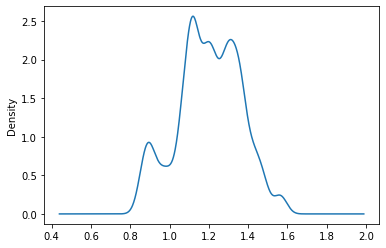

In [50]:
### So now I want to show the distribution for the EURUSD series just to make sure it is "Gaussian" enough


forex["EURUSD"].plot.kde()


In [51]:
## The shapiro-wilk test has a null-hypothesis that assumes the values of the variable are normally distributed (Gaussian)
## Below is this test on our variable to help us determine which loss function we want to use in our Machine Learning 
## algorithm. 



from scipy import stats



shapiro_test = stats.shapiro(forex["EURUSD"])
shapiro_test



/Users/floyd/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9871795177459717, pvalue=1.119165044172719e-22)

In [52]:
## The result shows that we have a p-value of close to 0, which seems like strong evidence that we cannot assume our data
## is normal. Thus, we will avoid using any probabilistic measurements for our loss function.


np.shape(y_sample_val)



(10000, 30, 3)

In [53]:
### ----------------------- The LSTM Recurrent Neural Network (RNN) Model ---------------------- ###

## We will start with just 20 epochs using the Nadam optimizer. We will use loss="mse" for our loss function, and
## we will use "accuracy" for the metric. 


from keras import callbacks


## early stop stops the algorithm once validation loss begins to get worse. Patience indicates that it will stop the algo
## after 3 epochs of no improvement in validation loss. The model will retain the best weights from from before the
## early stop to ensure that the model avoids any overfitting.



callback = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 3, 
                                        restore_best_weights = False)


model = keras.models.Sequential([
    keras.layers.RNN(LSTM_norm(300, input_shape=(None,10)), return_sequences= True),
    keras.layers.RNN(LSTM_norm(75), return_sequences= True),
    keras.layers.RNN(LSTM_norm(25), return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(duration))
])


opt = keras.optimizers.Nadam(learning_rate=0.1)


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss="mse", optimizer=opt, metrics=["accuracy",last_time_step_mse])
history = model.fit(X_sample_tr, y_sample_tr, epochs=20, callbacks=[callback],
                    validation_data=(X_sample_val, y_sample_val))


Epoch 1/20
313/313 [==============================] - 67s 215ms/step - loss: 0.0400 - accuracy: 0.3461 - last_time_step_mse: 0.0423 - val_loss: 0.0958 - val_accuracy: 0.3713 - val_last_time_step_mse: 0.0961
Epoch 2/20
313/313 [==============================] - 68s 217ms/step - loss: 0.0281 - accuracy: 0.3521 - last_time_step_mse: 0.0284 - val_loss: 0.0715 - val_accuracy: 0.3708 - val_last_time_step_mse: 0.0715
Epoch 3/20
313/313 [==============================] - 67s 214ms/step - loss: 0.0250 - accuracy: 0.3682 - last_time_step_mse: 0.0253 - val_loss: 0.1111 - val_accuracy: 0.3710 - val_last_time_step_mse: 0.1111
Epoch 4/20
313/313 [==============================] - 67s 215ms/step - loss: 0.0266 - accuracy: 0.3623 - last_time_step_mse: 0.0268 - val_loss: 0.2059 - val_accuracy: 0.3683 - val_last_time_step_mse: 0.2060
Epoch 5/20
313/313 [==============================] - 68s 216ms/step - loss: 0.0261 - accuracy: 0.3387 - last_time_step_mse: 0.0264 - val_loss: 0.0466 - val_accuracy: 0.367

In [54]:
## So the model has been trained, so now we will evaluate the model on the train, valid, test data sets

tr_accuracy = model.evaluate(X_sample_tr, y_sample_tr)
tr_accuracy = tr_accuracy[1]

val_accuracy = model.evaluate(X_sample_val, y_sample_val)
val_accuracy = val_accuracy[1]

test_accuracy = model.evaluate(X_sample_test, y_sample_test)
test_accuracy = test_accuracy[1]

print(f"""\nTraining accuracy: {round(tr_accuracy,3)}\n\nValidation accuracy: {round(val_accuracy,3)}
\nTesting accuracy: {round(test_accuracy,3)}""")

313/313 [==============================] - 15s 47ms/step - loss: 0.0185 - accuracy: 0.4087 - last_time_step_mse: 0.0180

Training accuracy: 0.39

Validation accuracy: 0.368

Testing accuracy: 0.409


In [55]:
## So the accuracies are pretty good, being between 36.3% and 40.7%. I'm impressed that the testing accuracy
## was so high, but we will see. Next step is to use the model to predict the values of EURUSD:
## [..., np.newaxis] will add a new axis and put y_pred_xx into it


y_pred_tr = model.predict(X_sample_tr)[..., np.newaxis]
y_pred_val = model.predict(X_sample_val)[..., np.newaxis]
y_pred_test = model.predict(X_sample_test)[..., np.newaxis]

In [56]:
### This mess is basically a function that maps the dates back to the forecast period. The function returns
### y_pred_dates which is the price forecast for the next 3 steps in the series (in this case it is July 5th, 6th, 7th)


def predict_price(y_pred, dates):
    y_pred_dates = np.empty(int(duration))*np.nan
    for d in range(0, int(max(dates))):
        index = np.where(dates==d)
    for i in range(0,duration):   
        y_pred_dates[i] = y_pred[index[0][i]][0][i][0]
    return y_pred_dates


y_pred_dates_test= predict_price(y_pred_test, pred_date_test)


In [57]:
## Comparing the forecast to the actual realized price action (data from Forex.com)


actual_closing_price = np.array([1.18593, 1.18234, 1.18050])
my_forecast = pd.DataFrame({"Forecast":y_pred_dates_test, "Actual":actual_closing_price})
my_forecast['Difference'] = my_forecast['Forecast'] - my_forecast['Actual']


In [58]:
my_forecast

,Forecast,Actual,Difference
0,1.051246,1.18593,-0.134684
1,1.049636,1.18234,-0.132704
2,1.048226,1.18050,-0.132274


In [59]:
### As we can see, the forecast underestimated the magnitude of the move in EURUSD. 
### Next I will generate expected return vs actual return if we were to short the EURUSD pair on Jul 2nd and close at the 
### end of July 7th (forecast period)

### Note:   1 pip is equal to 0.0001 in forex. We will use this to generate anticipated return or loss based on pips, 
### which can then easily be used to calculate dollar profit or loss. 


pip = 0.0001


expected_return = (forex["EURUSD"].iloc[-1] - my_forecast["Forecast"].iloc[2])/pip
actual_return = (forex["EURUSD"].iloc[-1] - my_forecast["Actual"].iloc[2])/pip

In [60]:

print(f"""Price as of close on Friday, July 2nd was {forex["EURUSD"].iloc[-1]},
and my model predicted {round(expected_return,5)} pips expected return and {round(actual_return,5)} pips actual return.""")


Price as of close on Friday, July 2nd was 1.1848000288009644,
and my model predicted 1365.74388 pips expected return and 43.00029 pips actual return.


In [ ]:
### So we can also see that the forecast saw EURUSD going higher initially, which we should obviously consider 
### before placing a trade. 

In [ ]:
### Say we sold 1 lot of EURUSD, this would have resulted in an expected return of $131.67 and an actual
### return of $430.00, not including the spread. 